In [53]:
from scipy.stats import multivariate_normal
import pybnb
from functools import partial
from sklearn.ensemble import IsolationForest

%load_ext autoreload
%autoreload 2

from BranchAndBoundSolver_hichem import BranchAndBoundSolver, BranchAndBoundTopDown, BranchAndBoundBottomUp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
training_points = multivariate_normal.rvs(size=(8,2))
point_to_be_classified = training_points[0]

# TopDown branch and bound solver 

In [55]:
print(f"point: {point_to_be_classified}")
problem = BranchAndBoundTopDown(training_points, point_to_be_classified, min_area_factor=0.1)
solver = pybnb.Solver(comm=None)
results = solver.solve(problem, absolute_gap=0)

point: [ 0.54323609 -0.16269348]
Starting branch & bound solve:
 - dispatcher pid: 22005 (HDHOUIB)
 - worker processes: 1
--------------------------------------------------------------------------------------------------------------------------
         Nodes        |                      Objective Bounds                       |              Work              
      Expl    Unexpl  |      Incumbent           Bound    Rel. Gap         Abs. Gap | Time (s)  Nodes/Sec Imbalance   Idle
         0         1  |            inf            -inf         inf%             inf |      0.0       0.00     0.00%      0
*        1         8  |            0.5           0.125   37.500000%           0.375 |      0.0     239.18     0.00%      0
*        2        15  |          0.375           0.125   25.000000%            0.25 |      0.0     234.17     0.00%      0
*       42       103  |           0.25           0.125   12.500000%           0.125 |      0.0    1103.24     0.00%      0
*      138         0  

In [56]:
problem.counter_counter

472

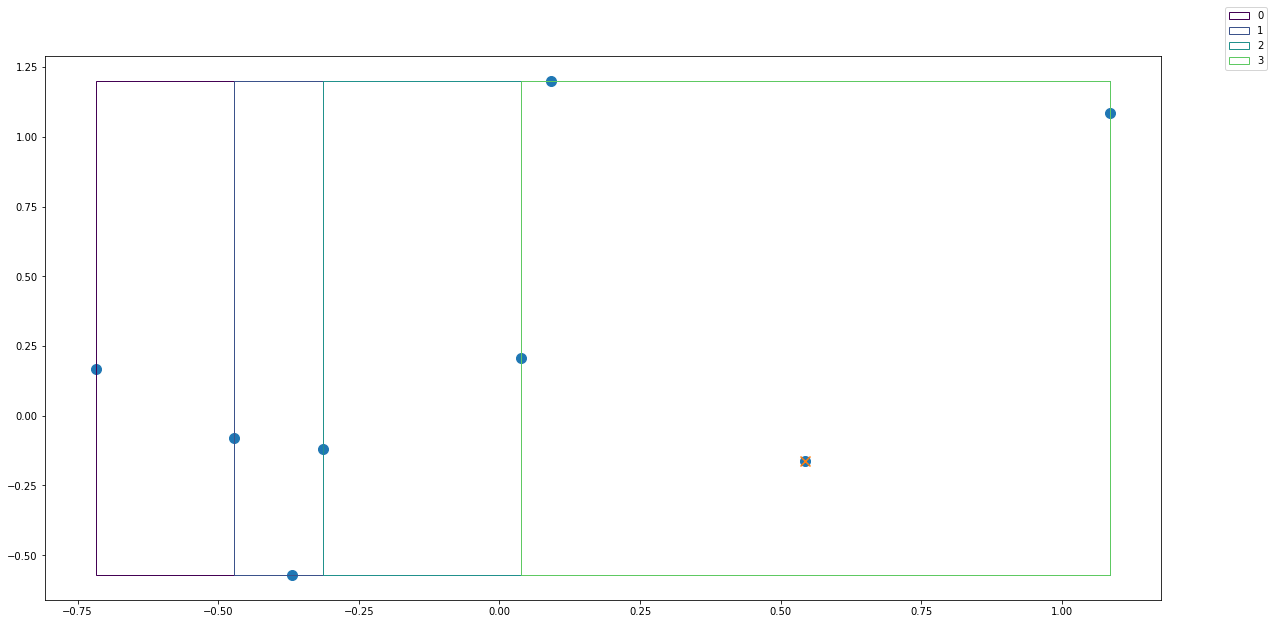

In [57]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

cmap = plt.get_cmap('viridis') # .colormaps['viridis']
def draw2dpattern(interval, ax, index, total):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(index/total),
        label=index
    )
    )

marker_size = 100
plt.scatter(x=training_points[:,0], y=training_points[:,1], s=marker_size)
plt.scatter(x=point_to_be_classified[0], y=point_to_be_classified[1], marker="x",  s=marker_size)
ax = plt.gca()
total = len(problem.trajectory)
for i, interval in enumerate(problem.trajectory):
    draw2dpattern(interval, ax, i, total)
ax.legend(bbox_to_anchor=(1.1, 1.1))
plt.show()


# BottomUp branch and bound solver 

In [58]:
training_points

array([[ 0.54323609, -0.16269348],
       [-0.71800948,  0.16754437],
       [ 1.08542154,  1.08562303],
       [ 0.03769718,  0.20670716],
       [-0.31291662, -0.11947715],
       [-0.3680921 , -0.57132585],
       [-0.47270315, -0.07882354],
       [ 0.09174234,  1.20053634]])

In [59]:
print(f"Bottom up: point to be classified: {point_to_be_classified}")
problem = BranchAndBoundBottomUp(training_points, point_to_be_classified, min_area_factor=0.0001)
solver = pybnb.Solver(comm=None)
results = solver.solve(problem, absolute_gap=0.0)

Bottom up: point to be classified: [ 0.54323609 -0.16269348]
Starting branch & bound solve:
 - dispatcher pid: 22005 (HDHOUIB)
 - worker processes: 1
--------------------------------------------------------------------------------------------------------------------------
         Nodes        |                      Objective Bounds                       |              Work              
      Expl    Unexpl  |      Incumbent           Bound    Rel. Gap         Abs. Gap | Time (s)  Nodes/Sec Imbalance   Idle
         0         1  |            inf            -inf         inf%             inf |      0.0       0.00     0.00%      0
*        1         4  |        7.11689       0.8896112   87.500000%     6.227278617 |      0.0     173.28     0.00%      0
*        4        11  |       6.227279       0.8896112   85.714286%     5.337667386 |      0.0     425.86     0.00%      0
*       14        29  |       5.337667       0.8896112   83.333333%     4.448056155 |      0.0    1183.42     0.00%  

In [60]:
problem.counter_counter, results.solution_status

(4076, 'optimal')

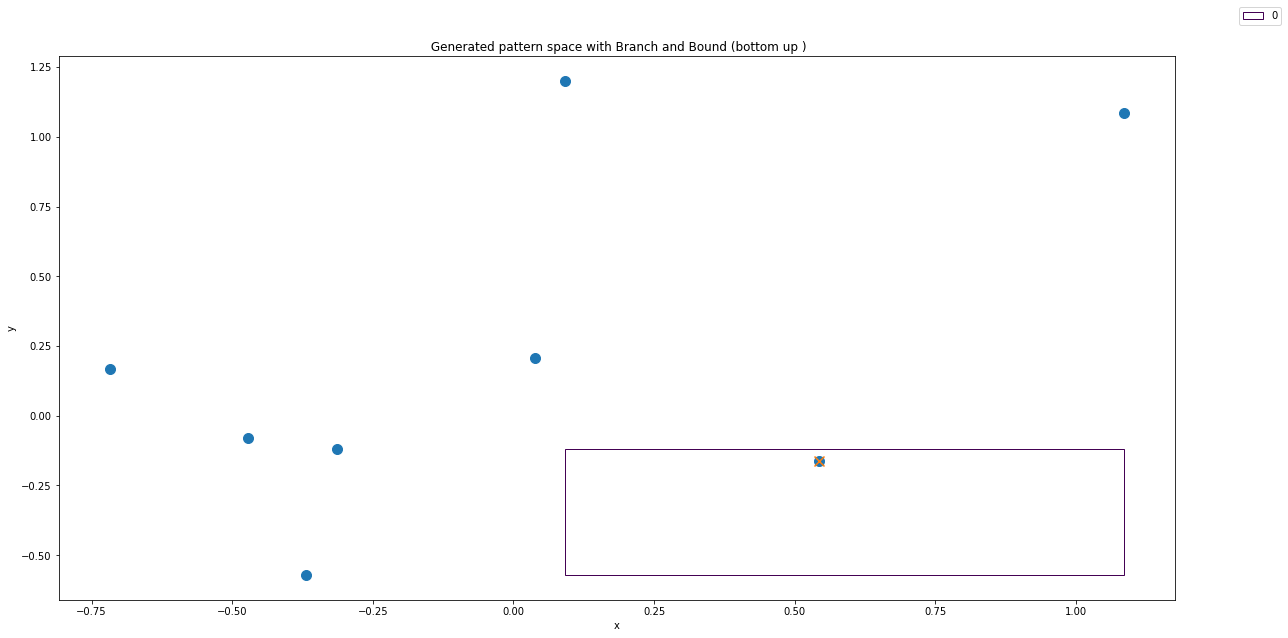

In [61]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

cmap = plt.get_cmap('viridis')
def draw2dpattern(interval, ax, index, total):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(index/total),
        label=index

    )
    )

marker_size = 100
plt.scatter(x=training_points[:,0], y=training_points[:,1], s=marker_size)
plt.scatter(x=point_to_be_classified[0], y=point_to_be_classified[1], marker="x", s=marker_size)
ax = plt.gca()
total = len(problem.trajectory)
#print("point_to_be_classified: ",point_to_be_classified)
#print("problem.trajectory: ",problem.trajectory)
for i, interval in enumerate(problem.trajectory):
    draw2dpattern(interval, ax, i, total)
    break
ax.legend(bbox_to_anchor=(1.1, 1.1))
plt.title(" Generated pattern space with Branch and Bound (bottom up )")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## Question: How to define the smallest pattern: 
    - Does it define itself (its own rectangle independently from the other datapoints)? 
    - Should it be defined using one point of the dataset or two points? 

## Continuing a Solve After Stopping

In [62]:
if results.solution_status in ("optimal",
                               "feasible"):
    queue = solver.save_dispatcher_queue()
    results = solver.solve(problem,
                           best_node=results.best_node,
                           initialize_queue=queue,
                           absolute_gap=1e-4)


Using non-default solver options:
 - absolute_gap: 0.0001 (default: 0)
 - best_node: Node(objective=0.8896112) (default: None)
 - initialize_queue: Queue(size=0) (default: <root>)

Starting branch & bound solve:
 - dispatcher pid: 22005 (HDHOUIB)
 - worker processes: 1
----------------------------------------------------------------------------------------------------------------------
         Nodes        |                    Objective Bounds                     |              Work              
      Expl    Unexpl  |      Incumbent           Bound    Rel. Gap     Abs. Gap | Time (s)  Nodes/Sec Imbalance   Idle
         0         0  |      0.8896112       0.8896112    0.000000%           0 |      0.0       0.00     0.00%      0
         0         0  |      0.8896112       0.8896112    0.000000%           0 |      0.0       0.00     0.00%      0
----------------------------------------------------------------------------------------------------------------------

Absolute optimality

# Implementing PAC RPAD

In [63]:
from typing import Callable
import numpy as np
from patterns import AxisAlignedHyperRectangle, find_bounding_pattern

class PACRPAD:
    """
    Superclass for all PAC-RPAD implementations
    """
    def __init__(self, tau, epsilon, delta):
        self.tau = tau
        self.epsilon = epsilon
        self.delta = delta
        self.find_min_f_hat: Callable[[np.ndarray], float] = lambda *_: 0. #this function should be provided by each subclass based on training data

    def has_rare_pattern(self, point) -> bool:
        return self.find_min_f_hat(point) <= self.tau + self.epsilon / 2

In [64]:
class AxisAlignedHyperRectanglePACRPAD(PACRPAD):
    def __init__(self, tau, epsilon, delta):
        super().__init__(tau, epsilon, delta)
        self.solver = None

    def construct_f_hat_estimator(self, training_data, absolute_gap=0.0, queue_strategy="bound"):
        self.solver = partial(BranchAndBoundTopDown, training_data = training_data, min_area_factor=0.1)
        self.find_min_f_hat = lambda point: pybnb.Solver(comm=None).solve(self.solver(point_to_be_classified = point),
                                                                             absolute_gap=absolute_gap,
                                                                             queue_strategy=queue_strategy
                                                                             ).objective

class RandomForestApproximatePACRPAD(PACRPAD):
    def __init__(self, tau, epsilon, delta):
        super().__init__(tau, epsilon, delta)
        self.random_forest = None

    def construct_f_hat_estimator(self, training_data, n_estimators=100):
        self.random_forest = IsolationForest(random_state=0, n_estimators=n_estimators).fit(training_data)
        bounding_pattern = find_bounding_pattern(training_data)

        def find_pattern_in_tree(tree, point:np.array):
            features = tree.feature
            thresholds = tree.threshold
            intervals = bounding_pattern.intervals

            point = point.astype(np.float32).reshape(1,-1)
            node_index = list(tree.decision_path(point).indices)
            #going through the non-leaf nodes to and updating threshold along the way:
            while len(node_index) > 1:
                node_id = node_index.pop()
                f = features[node_id]
                t = thresholds[node_id]
                intervals[point[f] > t,f] = t
            # the output of this function is the numper of samples in the pattern, together with the rectangle
            return tree.n_node_samples[node_index[0]], AxisAlignedHyperRectangle(intervals)

        def evaluate_f_hat(tree, point):
            samples, pattern = find_pattern_in_tree(tree, point)
            return (samples * bounding_pattern.area)/(pattern.area * len(training_data))

        self.find_min_f_hat = lambda point : min([evaluate_f_hat(estimator.tree_, point) for estimator in self.random_forest.estimators_])

## Testing branch and bound version 

In [65]:
delta = 0.1
epsilon = 0.1
tau = 0.1
exact = AxisAlignedHyperRectanglePACRPAD(tau, epsilon, delta)
exact.construct_f_hat_estimator(training_points)
exact.has_rare_pattern(training_points[0])

Starting branch & bound solve:
 - dispatcher pid: 22005 (HDHOUIB)
 - worker processes: 1
--------------------------------------------------------------------------------------------------------------------------
         Nodes        |                      Objective Bounds                       |              Work              
      Expl    Unexpl  |      Incumbent           Bound    Rel. Gap         Abs. Gap | Time (s)  Nodes/Sec Imbalance   Idle
         0         1  |            inf            -inf         inf%             inf |      0.0       0.00     0.00%      0
*        1         8  |            0.5           0.125   37.500000%           0.375 |      0.0     235.23     0.00%      0
*        2        15  |          0.375           0.125   25.000000%            0.25 |      0.0     390.94     0.00%      0
*       42       103  |           0.25           0.125   12.500000%           0.125 |      0.0    1568.46     0.00%      0
*      138         0  |          0.125           0.125 

True

In [66]:
labels_b_and_b_top_down = [exact.has_rare_pattern(x_train) for x_train in training_points]

Starting branch & bound solve:
 - dispatcher pid: 22005 (HDHOUIB)
 - worker processes: 1
--------------------------------------------------------------------------------------------------------------------------
         Nodes        |                      Objective Bounds                       |              Work              
      Expl    Unexpl  |      Incumbent           Bound    Rel. Gap         Abs. Gap | Time (s)  Nodes/Sec Imbalance   Idle
         0         1  |            inf            -inf         inf%             inf |      0.0       0.00     0.00%      0
*        1         8  |            0.5           0.125   37.500000%           0.375 |      0.0     268.11     0.00%      0
*        2        15  |          0.375           0.125   25.000000%            0.25 |      0.0     398.49     0.00%      0
*       42       103  |           0.25           0.125   12.500000%           0.125 |      0.0     959.84     0.00%      0
*      138         0  |          0.125           0.125 

In [67]:
labels_b_and_b_top_down

[True, True, True, True, True, True, True, True]